# Predicting Loan Defaults
   ### Using Lending Club Data and Macroeconomic Indicators
   ### Brendan Philbin

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dmba import classificationSummary

In [2]:
pd.options.display.max_rows = 150


In [3]:
os.getcwd()

'C:\\Users\\bphil\\Documents\\Baruch Classes\\Spring 2021\\BUS9430'

## I. Lending Club Data

### A. Importing Data and Looking at Specifics

In [4]:
accepted_df = pd.read_csv("accepted_2007_to_2018Q4.csv/accepted_2007_to_2018Q4.csv")

accept_col = accepted_df.columns

for i in accept_col:
    print(i)

C:\Users\bphil\Anaconda3\envs\Applied NLP\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
pymnt_plan
url
desc
purpose
title
zip_code
addr_state
dti
delinq_2yrs
earliest_cr_line
fico_range_low
fico_range_high
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
next_pymnt_d
last_credit_pull_d
last_fico_range_high
last_fico_range_low
collections_12_mths_ex_med
mths_since_last_major_derog
policy_code
application_type
annual_inc_joint
dti_joint
verification_status_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
to

In [5]:
print('Datset size:',accepted_df.shape)

Datset size: (2260701, 151)


### Narrowing Down to Paid off and Defaulted Loans

In [6]:
import nltk
loan_status = accepted_df.loan_status

loan_fd = nltk.FreqDist(loan_status)
loan_fd.most_common()

[('Fully Paid', 1076751),
 ('Current', 878317),
 ('Charged Off', 268559),
 ('Late (31-120 days)', 21467),
 ('In Grace Period', 8436),
 ('Late (16-30 days)', 4349),
 ('Does not meet the credit policy. Status:Fully Paid', 1988),
 ('Does not meet the credit policy. Status:Charged Off', 761),
 ('Default', 40),
 (nan, 33)]

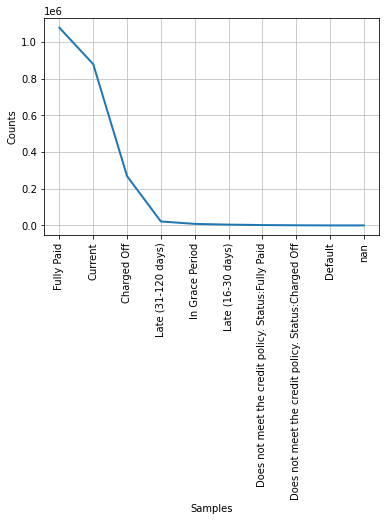

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [7]:
loan_fd.plot()

In [8]:
loan_df = accepted_df.query('loan_status == ["Fully Paid","Charged Off"]')

print('Revised Dataset Size:',loan_df.shape)

Revised Dataset Size: (1345310, 151)


### B. Removing Null Values

In [9]:
nulls = loan_df.isnull().sum(axis=0)

loan_cols = loan_df.columns
tups = []

for i in range(0,len(loan_cols)):
    x = loan_cols[i]
    y = nulls[i]
    z = (x,y)
    tups.append(z)
    
final_cols = [a for (a,b) in tups if b < 100000]
loan_final = loan_df[final_cols]

In [10]:
loan_final.shape

(1345310, 90)

### C. Converting to Datetime

In [11]:
import datetime
loan_final["issue_d"] = pd.to_datetime(loan_final["issue_d"])

C:\Users\bphil\Anaconda3\envs\Applied NLP\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### D. Digging Deeper - Object Variables

In [12]:
loan_cols = loan_final.columns
types = []

for col in loan_cols:
    x = loan_final[col].dtype
    y = (col,x)
    types.append(y)

In [13]:
objects = [a for (a,b) in types if b == 'O']

for i in objects:
    x = i
    y = len(loan_final[x].unique())
    print(x,y)

id 1345310
term 2
grade 7
sub_grade 35
emp_title 378354
emp_length 12
home_ownership 6
verification_status 3
loan_status 2
pymnt_plan 1
url 1345310
purpose 14
title 61683
zip_code 944
addr_state 51
earliest_cr_line 739
initial_list_status 2
last_pymnt_d 136
last_credit_pull_d 141
application_type 2
hardship_flag 1
disbursement_method 2
debt_settlement_flag 2


In [14]:
drops = ['id','emp_title','pymnt_plan','url','title','zip_code','earliest_cr_line','last_pymnt_d',
         'last_credit_pull_d','hardship_flag','disbursement_method','debt_settlement_flag']

loan_final = loan_final.drop(columns = drops)

In [15]:
new_obj = [col for col in loan_final.columns if loan_final[col].dtype == 'O']

for col in new_obj:
    loan_final[col] = loan_final[col].astype('category')
    

loan_final.dtypes

loan_amnt                            float64
funded_amnt                          float64
funded_amnt_inv                      float64
term                                category
int_rate                             float64
installment                          float64
grade                               category
sub_grade                           category
emp_length                          category
home_ownership                      category
annual_inc                           float64
verification_status                 category
issue_d                       datetime64[ns]
loan_status                         category
purpose                             category
addr_state                          category
dti                                  float64
delinq_2yrs                          float64
fico_range_low                       float64
fico_range_high                      float64
inq_last_6mths                       float64
open_acc                             float64
pub_rec   

In [16]:
loan_final['term'] = loan_final['term'].replace([' 36 months'],36)
loan_final['term'] = loan_final['term'].replace([' 60 months'],60)

In [17]:
loan_final['term'] = loan_final['term'].astype('int')

### E. Converting Target Variable to Numerical Value

In [18]:
temp = pd.Series(loan_final['loan_status'])
status = []
for i in temp:
    if i == "Fully Paid":
        x = 1
        
    else:
        x = 0
        
    status.append(x)
    
loan_final['target'] = status

## II. Federal Reserve Economic Dataset

In [19]:
import quandl
from datetime import datetime as dt
api_key = 'ymBkphS_8Y-bLCiXviqe'
quandl.ApiConfig.api_key = api_key

fred_indicators = ["FRED/DFF","FRED/DPRIME","FRED/UNEMPLOY","FRED/DSPI","FRED/PSAVERT","FRED/CPIAUCSL"]

macro_df = quandl.get(fred_indicators,start_date = "2007-01-01",end_date="2018-12-31", collapse = "monthly")
macro_df.reset_index(inplace=True)

macro_df['issue_d']= macro_df['Date'].astype('datetime64[M]')

In [20]:
macro_df.head()

,Date,FRED/DFF - Value,FRED/DPRIME - Value,FRED/UNEMPLOY - Value,FRED/DSPI - Value,FRED/PSAVERT - Value,FRED/CPIAUCSL - Value,issue_d
0,2007-01-31,5.33,8.25,7116.0,10298.0,3.6,203.437,2007-01-01
1,2007-02-28,5.41,8.25,6927.0,10369.9,4.0,204.226,2007-02-01
2,2007-03-31,5.30,8.25,6731.0,10442.7,4.3,205.288,2007-03-01
3,2007-04-30,5.29,8.25,6850.0,10463.9,4.1,205.904,2007-04-01
4,2007-05-31,5.28,8.25,6766.0,10486.7,3.9,206.755,2007-05-01


In [21]:
names = ['Date','DFF','DPRIME','UNEMPLOYMENT','DSPI','SAVERT','CPIAUCSL','issue_d']

macro_df.columns = names
macro_df.head()

,Date,DFF,DPRIME,UNEMPLOYMENT,DSPI,SAVERT,CPIAUCSL,issue_d
0,2007-01-31,5.33,8.25,7116.0,10298.0,3.6,203.437,2007-01-01
1,2007-02-28,5.41,8.25,6927.0,10369.9,4.0,204.226,2007-02-01
2,2007-03-31,5.30,8.25,6731.0,10442.7,4.3,205.288,2007-03-01
3,2007-04-30,5.29,8.25,6850.0,10463.9,4.1,205.904,2007-04-01
4,2007-05-31,5.28,8.25,6766.0,10486.7,3.9,206.755,2007-05-01


## III. Finalizing Dataset

In [22]:
final_df = loan_final.merge(macro_df, on = 'issue_d',how = 'inner')

final_df.dtypes

loan_amnt                            float64
funded_amnt                          float64
funded_amnt_inv                      float64
term                                   int32
int_rate                             float64
installment                          float64
grade                               category
sub_grade                           category
emp_length                          category
home_ownership                      category
annual_inc                           float64
verification_status                 category
issue_d                       datetime64[ns]
loan_status                         category
purpose                             category
addr_state                          category
dti                                  float64
delinq_2yrs                          float64
fico_range_low                       float64
fico_range_high                      float64
inq_last_6mths                       float64
open_acc                             float64
pub_rec   

## IV. Baseline Models

In [23]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import r2_score

In [24]:
model_df = pd.get_dummies(final_df,prefix_sep = '_',drop_first = True)

model_df = model_df.dropna()
model_df = model_df.reset_index()

In [29]:
target1 = model_df['target']
target1 = target1.astype('float')
predictors1 = model_df.drop(columns = ['loan_status_Fully Paid','target','Date','issue_d'])


### Creating Logistic Regression Function

In [33]:
def log_reg(target,predictors):
    ## Preparing the train and test data
    trainx, validx, trainy, validy = train_test_split(predictors, target, test_size=0.3, random_state=1)
    
    ## Fitting the data to a logistic regression model
    logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
    logit_reg.fit(trainx, trainy)
    
    ## Printing out coefficient scores
    coefs = logit_reg.coef_[0]
    cols = predictors.columns
    scores = []

    for i in range(0,len(coefs)):
        x = (coefs[i],cols[i])
        scores.append(x)
    
    scores = [(round(a,5),b) for (a,b) in scores]
    scores = sorted(scores, reverse= True)
    scores
    
    ## Printing out Confusion Matrix
    print ('Logistic Regression Training Data:')
    print(classificationSummary(trainy, logit_reg.predict(trainx)))
    print('________________________________________')

    #Test performance
    print('Logistic Regression Test Data:')
    print(classificationSummary(validy,logit_reg.predict(validx)))
    
    #Printing R-Squared
    y_score = logit_reg.predict_proba(validx)[:,1]
    print('R-Squared Score:',r2_score(validy,y_score))
    
    #Printing AUC Score
    print('ROC - AUC Score:',roc_auc_score(validy,y_score))
    
    ## ROC Score
    y_score = logit_reg.predict_proba(validx)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(validy, y_score)
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - Logistic Regression')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
    

### Creating Naive Bayes Function

In [27]:
from sklearn.naive_bayes import GaussianNB
def nb_model(target,predictors):
    
    trainx, validx, trainy, validy = train_test_split(predictors, target, test_size=0.3, random_state=1)
    
    nb = GaussianNB()
    nb.fit(trainx, trainy)
    
    # training performance 
    print ('Naive Bayes Training Data:')
    print(classificationSummary(trainy, nb.predict(trainx)))
    print('________________________________________')
    
    print('Naive Bayes Test Data')
    print(classificationSummary(validy,nb.predict(validx)))
    
    #Printing R-Squared
    y_score = nb.predict_proba(validx)[:,1]
    print('R-Squared Score:',r2_score(validy,y_score))
    
    #Printing AUC Score
    print('ROC - AUC Score:',roc_auc_score(validy,y_score))
    
    from sklearn.inspection import permutation_importance

    imps = permutation_importance(nb, trainx, trainy)
    imp_mean = imps.importances_mean
    cols = predictors.columns
    scores = []

    for i in range(0,len(imp_mean)):
        x = (imp_mean[i],cols[i])
        scores.append(x)
    
    scores = [(round(a,5),b) for (a,b) in scores]
    scores = sorted(scores, reverse= True)
    print(scores)
    
    
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(validy, y_score)
    
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - Naive Bayes')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Baseline LR Scores

C:\Users\bphil\Anaconda3\envs\Applied NLP\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logistic Regression Training Data:
Confusion Matrix (Accuracy 0.9968)

       Prediction
Actual      0      1
     0 175843   2867
     1      0 705040
None
________________________________________
Logistic Regression Test Data:
Confusion Matrix (Accuracy 0.9967)

       Prediction
Actual      0      1
     0  75059   1258
     1      0 302434
None
R-Squared Score: 0.9848681343303289
ROC - AUC Score: 0.9995253996775388


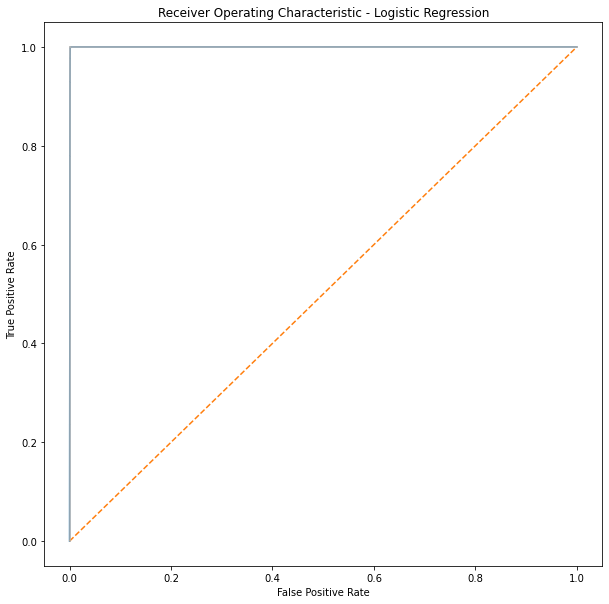

In [34]:
log_reg(target1,predictors1)

### Baseline Naive Bayes Scores

In [35]:
target1 = model_df['target']
target1 = target1.astype('float')
predictors1 = model_df.drop(columns = ['loan_status_Fully Paid','target','Date','issue_d'])

Naive Bayes Training Data:
Confusion Matrix (Accuracy 0.9610)

       Prediction
Actual      0      1
     0 156527  22183
     1  12247 692793
None
________________________________________
Naive Bayes Test Data
Confusion Matrix (Accuracy 0.9612)

       Prediction
Actual      0      1
     0  66828   9489
     1   5222 297212
None
R-Squared Score: 0.7971889842829354
ROC - AUC Score: 0.9849454236509672


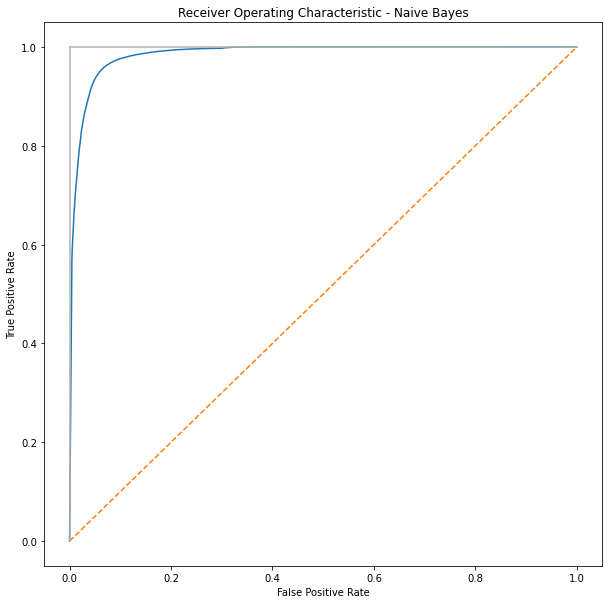

In [36]:
nb_model(target1,predictors1)

## V. Model Re-Run - Removing Payment Related Variables

In [25]:
model2_drops = ['total_rec_prncp','total_pymnt_inv','total_pymnt','last_pymnt_amnt','loan_status_Fully Paid']

model_df2 = model_df.drop(columns = model2_drops)

target2 = model_df2['target']
target2 = target2.astype('float')
predictors2 = model_df2.drop(columns = ['target','Date','issue_d'])

C:\Users\bphil\Anaconda3\envs\Applied NLP\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logistic Regression Training Data:
Confusion Matrix (Accuracy 0.9215)

       Prediction
Actual      0      1
     0 110851  67859
     1   1525 703515
None
________________________________________
Logistic Regression Test Data:
Confusion Matrix (Accuracy 0.9220)

       Prediction
Actual      0      1
     0  47437  28880
     1    681 301753
None
R-Squared Score: 0.625457171636038
ROC - AUC Score: 0.9586136882676699


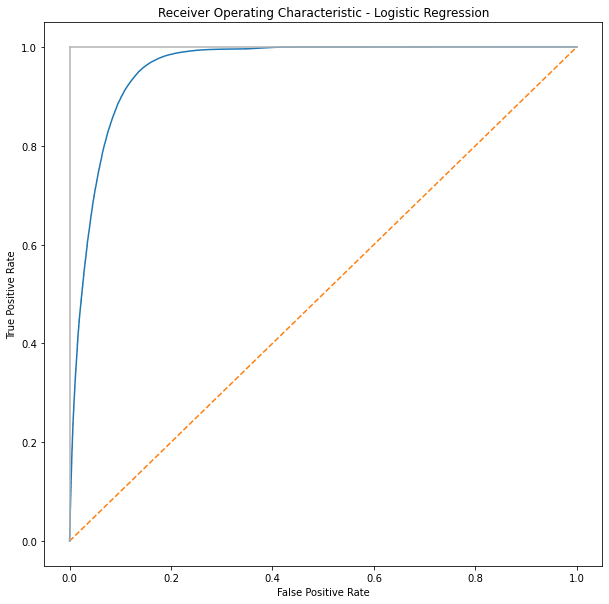

In [38]:
log_reg(target2,predictors2)

In [28]:
nb_model(target2,predictors2)

Naive Bayes Training Data:
Confusion Matrix (Accuracy 0.9396)

       Prediction
Actual      0      1
     0 131853  46857
     1   6526 698514
None
________________________________________
Naive Bayes Test Data
Confusion Matrix (Accuracy 0.9402)

       Prediction
Actual      0      1
     0  56433  19884
     1   2782 299652
None
R-Squared Score: 0.6671359782057917
ROC - AUC Score: 0.9610727731273357


KeyboardInterrupt: 

## VI. Removing Payment and Loan Related Data
### Focusing here on applicant-related and macro data

In [40]:
keeps = ['target','loan_amnt','term','int_rate','grade','sub_grade','emp_length','home_ownership','annual_inc',
        'verification_status','issue_d','purpose','addr_state','fico_range_low','fico_range_high','last_fico_range_low',
        'last_fico_range_high','tax_liens','tot_hi_cred_lim']

loan3 = loan_final[keeps]
model3 = loan3.merge(macro_df,on = 'issue_d',how = 'inner')

model_df3 = pd.get_dummies(model3,prefix_sep = '_',drop_first = True)

model_df3 = model_df3.dropna()
model_df3 = model_df3.reset_index()

In [41]:
target3 = model_df3['target']
target3 = target3.astype('float')
predictors3 = model_df3.drop(columns = ['target','Date','issue_d'])

Logistic Regression Training Data:
Confusion Matrix (Accuracy 0.9019)

       Prediction
Actual      0      1
     0 125765  55400
     1  32367 680916
None
________________________________________
Logistic Regression Test Data:
Confusion Matrix (Accuracy 0.9025)

       Prediction
Actual      0      1
     0  53428  23648
     1  13725 292534
None
R-Squared Score: 0.5603327310996948
ROC - AUC Score: 0.9456955176242925


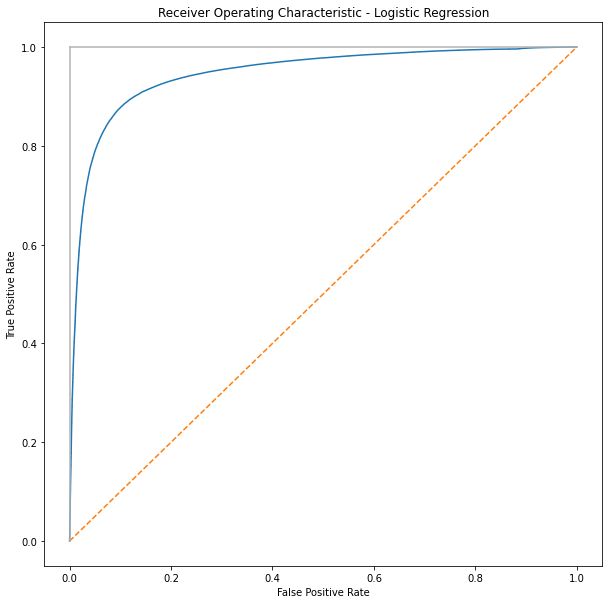

In [42]:
log_reg(target3,predictors3)

Naive Bayes Training Data:
Confusion Matrix (Accuracy 0.8987)

       Prediction
Actual      0      1
     0 137450  43715
     1  46892 666391
None
________________________________________
Naive Bayes Test Data
Confusion Matrix (Accuracy 0.8999)

       Prediction
Actual      0      1
     0  58629  18447
     1  19921 286338
None
R-Squared Score: 0.5038237183250203
ROC - AUC Score: 0.9345989651412797


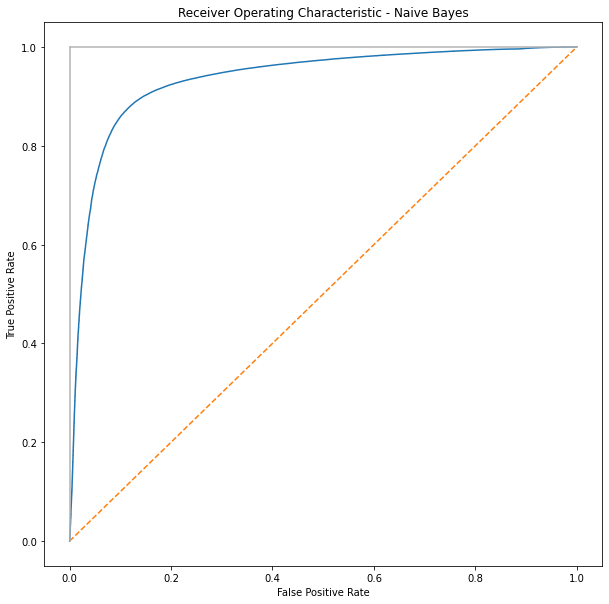

In [43]:
nb_model(target3,predictors3)